# qTPU Basics

In this brief tutorial we go through the process of 
1. compiling a large quantum circuit into an efficient `hybrid tensor network`, consisting of classical- and smaller quantum-tensors, and
2. contracting a hybrid tensor network using both classical and quantum devices to obtain the result of the circuit.

In [1]:
import numpy as np
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from IPython.display import display
import qtpu

We start by creating a random ansatz with linear entanglement:

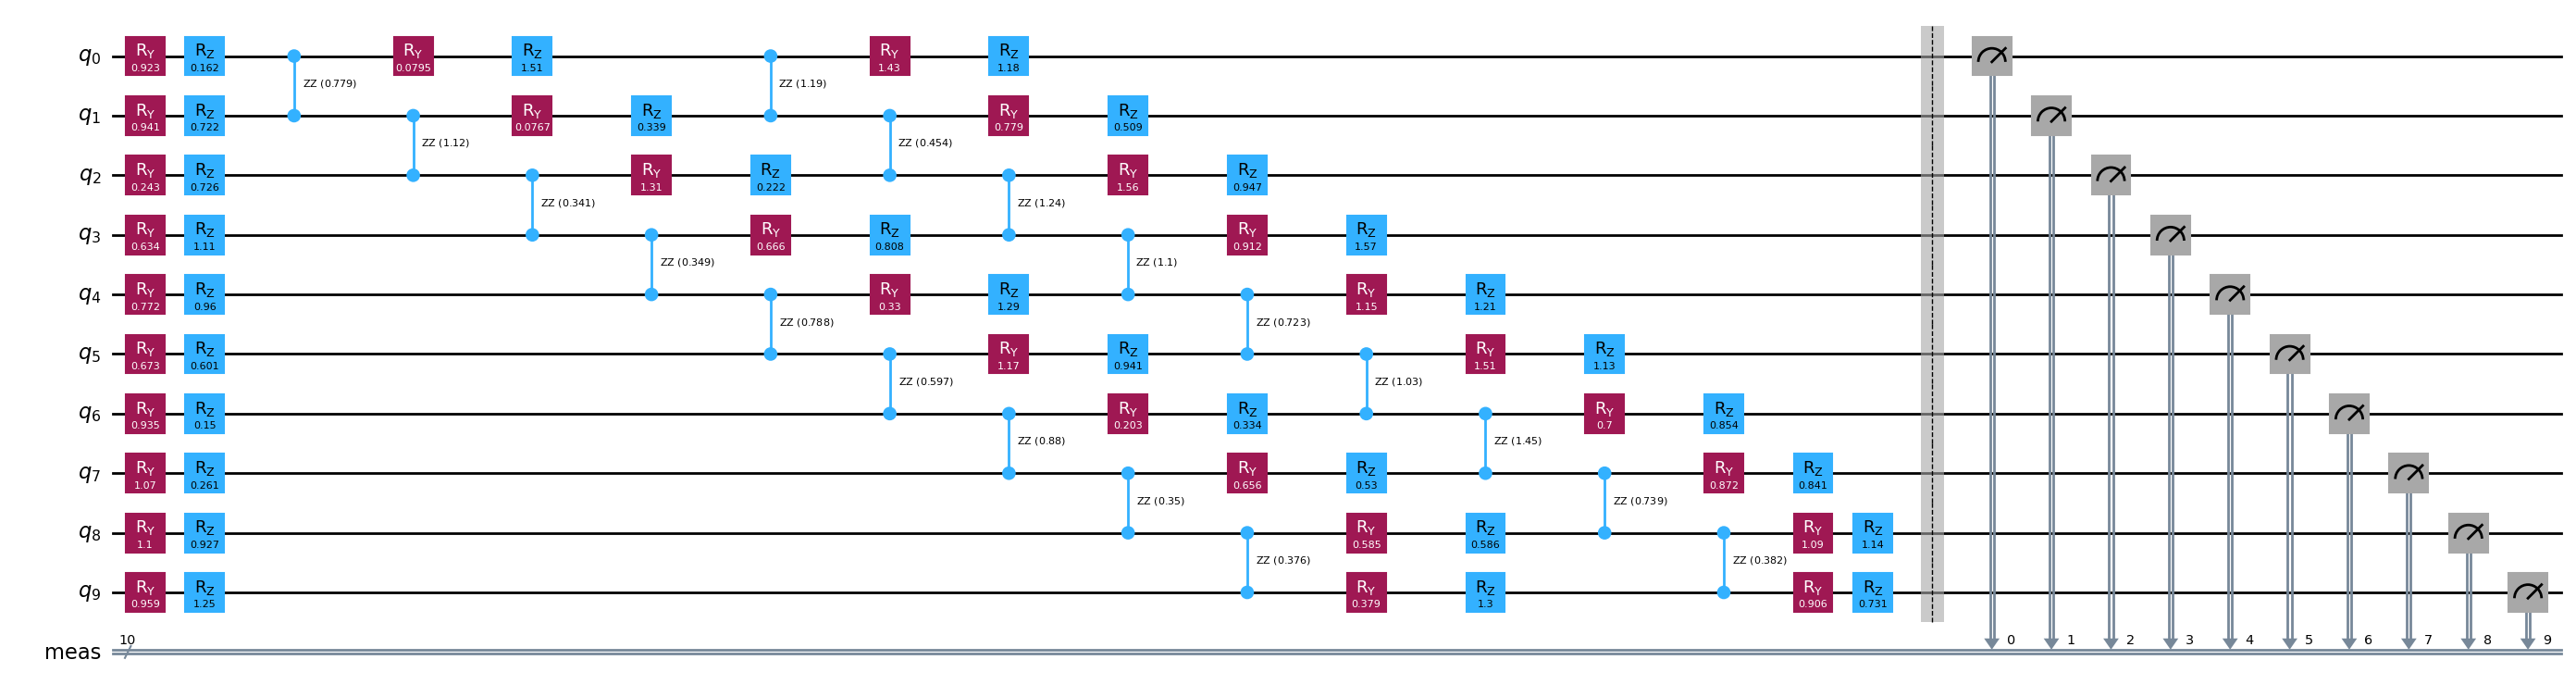

In [2]:
N = 10
circuit = TwoLocal(N, ["ry", "rz"], "rzz", entanglement="linear", reps=2).decompose()
circuit = circuit.assign_parameters(
    {param: np.random.rand() * np.pi / 2 for param in circuit.parameters}
)
# circuit = QuantumCircuit(N)
# circuit.h(0)
# circuit.cx(range(0, N-1), range(1, N))
# circuit.measure_all()

from qiskit.circuit.random import random_circuit

# circuit = random_circuit(7, 15, max_operands=2, seed=1242)

# from qiskit.circuit import ClassicalRegister
# circuit.add_register(ClassicalRegister(3))
# circuit.measure(range(2, 5), range(3))

circuit.measure_all()

circuit.draw("mpl", fold=-1)

## Compiling (cutting) the circuit

To compile the circuit into an efficient hybrid tensor network, we can use the `qtpu.cut` function. This function uses hyperparameter-optimization to find a good partitioning of the circuit, and then creates a hybrid TN of the partitioned circuit.
In this case, we use the terminator `reach_num_qubits(N//2)` to specify that we want the quantum-tensors to use at most `N/2` qubits.

In [3]:
from qtpu.helpers import expval_quimb
cc = circuit.copy()
cc.remove_final_measurements()
expval_quimb(cc)

0.0028160787753182103

  0%|          | 0/50 [00:00<?, ?it/s]

Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
Termination condition not met
[ 30.  24.  30.  30.  24.  30.  30.  24.  30. 450.  30.  30.  30.  30.
  30.  30.  30.  30.  30.]
True


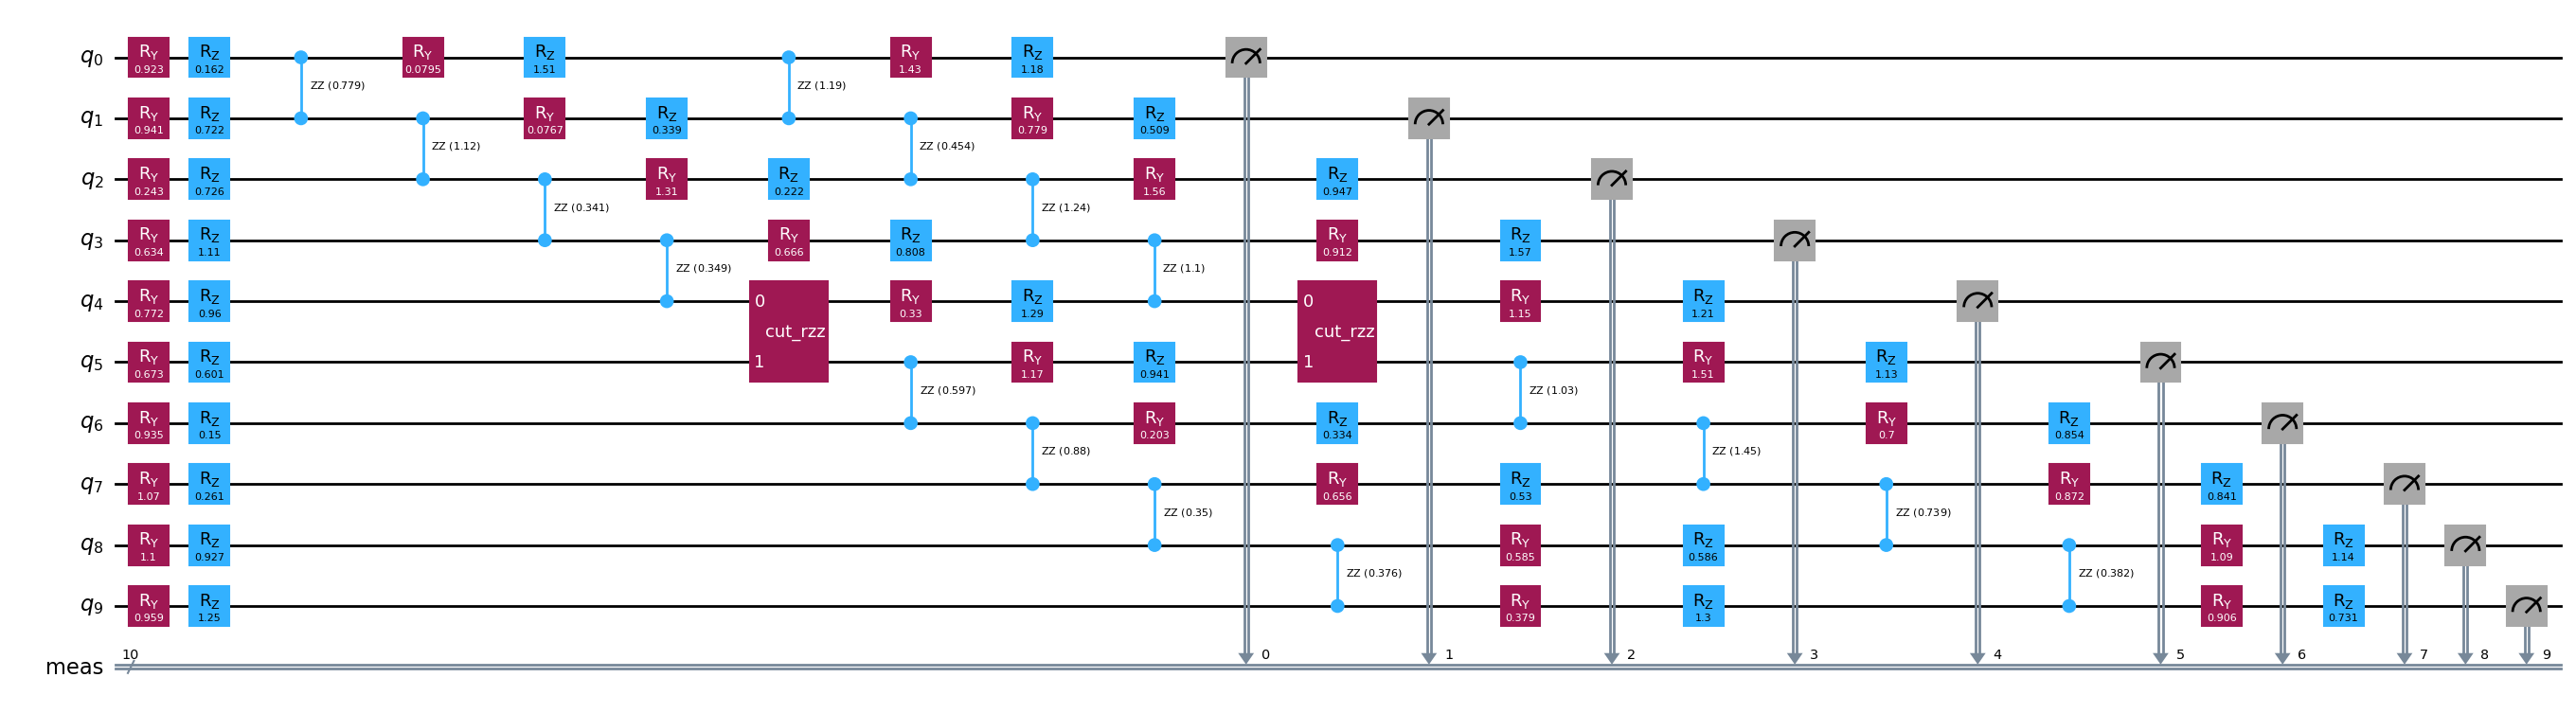

In [4]:
from qtpu.compiler.terminators import reach_num_qubits

cut_circuit = qtpu.cut(
    circuit,
    terminate_fn=reach_num_qubits(6),
    max_cost=1000,
    compression_methods=["qubits"],
    show_progress_bar=True,
    n_trials=50,
)
cut_circuit.draw("mpl", fold=-1)

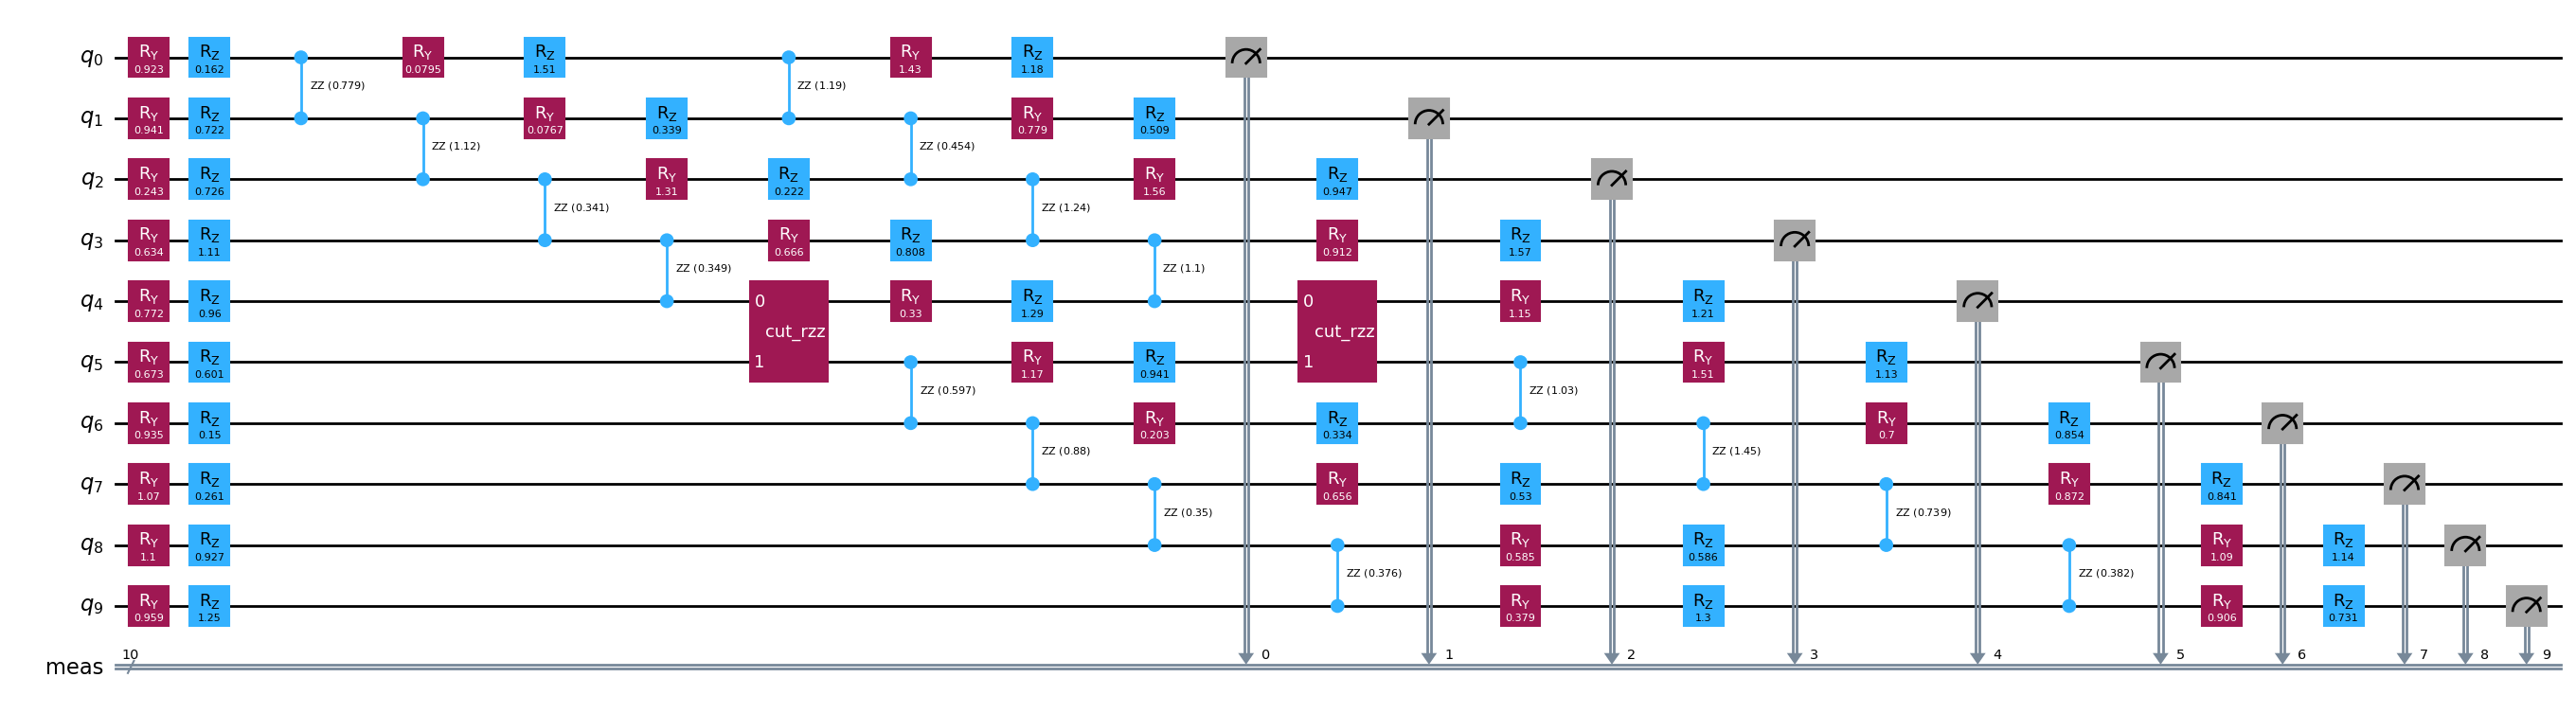

In [5]:
from qtpu.circuit import circuit_to_hybrid_tn, cuts_to_moves


cut_circuit = cuts_to_moves(cut_circuit)

# cut_circuit = wire_cuts_to_move(cut_circuit)

cut_circuit.draw('mpl', fold=-1)    
# print(htn)

# htn.quimb_tn().draw()

# from qtpu.contract2 import contract

# contract(htn)

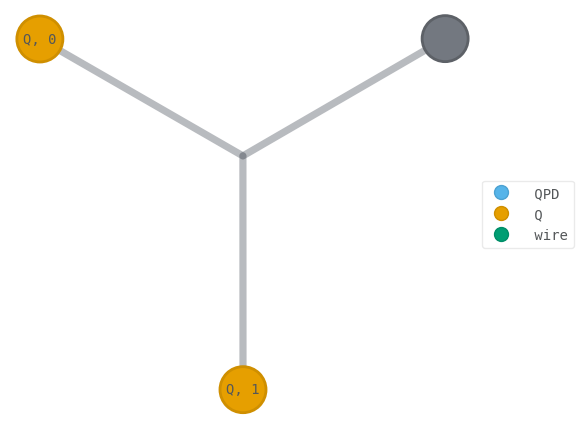

72


In [6]:
htn = circuit_to_hybrid_tn(cut_circuit)
# htn.approximate(tolerance=0.1)
# htn.sample(1000)
# fuse(htn)
# approximate(htn, tolerance=0.01)
tn = htn.to_tensor_network()
tn.draw(color=["QPD", "Q", "wire"])
print(tn.contraction_cost(optimize='auto'))

In [7]:
from qtpu.contract import contract, evaluate_hybrid_tn

# from qtpu.evaluate import evaluate_backend
from qiskit_aer.primitives import Sampler

# backend = AerSimulator()


from qiskit_aer.primitives import EstimatorV2



res = contract(htn, EstimatorV2())


Evaluating 72 circuits


In [8]:
from qiskit.primitives import Sampler, Estimator


ref_circ = circuit.copy()
ref_circ.remove_final_measurements()
ref_expval = Estimator().run(ref_circ, ["Z" * N]).result().values[0]

print("Fidelities:")
print(ref_expval, res)
# print(hellinger_fidelity(ref_samples, res.nearest_probability_distribution()))

Fidelities:
0.0028160787753182433 0.0028160787753181557


In [9]:
from qiskit.primitives import Sampler, Estimator
from qiskit.quantum_info import hellinger_fidelity

ref_samples = Sampler().run(circuit, shots=1000000).result().quasi_dists[0]

ref_circ = circuit.copy()
ref_circ.remove_final_measurements()
ref_expval = Estimator().run(ref_circ, ["Z" * N]).result().values[0]

print("Fidelities:")
print(ref_expval, res)
print(hellinger_fidelity(ref_samples, res.nearest_probability_distribution()))
# print(1 - abs(ref_expval - result_exp))

Fidelities:
0.0028160787753182433 0.0028160787753181557


AttributeError: 'float' object has no attribute 'nearest_probability_distribution'